In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import os

from tqdm import tqdm
from cycler import cycler

from astropy.io import fits

import corsikaio

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
# All parameters

# Ice Parameters (from Balco?)
z_start = 96.5 # starting real depth of model (m)
z_deep = 300 # end depth (m)
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

age_scale_file = 'DomeC_age_scale_Apr2023.csv'
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv'

# Primary spectrum parameters
corsika_folder = 'proton_fits' #Corsika data
slope = -2.7 #Technically an independent variable

# ALtitude adjustment parameters (from Balco?)
pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C
H = (1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# table for muons in standard rock in Groom and others 2001
# g/cm^2
h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

# Convergence depth for Vertical Flux adjustment (from Balco?)
h_end=2e3

#Vertical Flux Parameters (cited by Heisinger)
p_vf = [258.5,   #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
#Phi_v = p[0] * np.exp(p[1] * h) / (h + p[2]) / ((h+p[3])**p[4] + p[5])  # cm^-2 s^-1 sr^-1

# Zenith dependence parameters (cited by Heisinger)
p_n = [3.21,     #p0
       0.297,    #p1
       42,       #p2
       1.21e-3]  #p3

#n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)

# Negative muon ratio (Cited by Heisinger)
K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]

# Energy loss parameters (Gaisser)
a = 0.227 #(GeV cm^2/hg) energy loss due to ionization IN ROCK
b = 2.44e-4 #(cm^2/hg) sum of fractional radiation losses IN ROCK

# Negative Muon Capture parameters (Heisinger)
f_C = 1 # value should be absolute
f_D = 0.1828 #error unknown
f_star, df_star = 0.137, 0.011 
#f_star, df_star = 4.4e-3/f_C/f_D, 2.6e-3/f_C/f_D

# Fast Muon Interaction parameters (Heisinger)
sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
alpha = 0.75
#sigma_190, dsigma_190 = 2.4e-30*190**alpha, 1.8e-30*190**alpha #Dyonisius 2023
#sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
N = 6.022e23 / 0.1802 # hg^-1

# Decay parameter
lambd=1.21e-4 #yr^-1

# Production rate adjustment from Taylor Glacier data
f_neg = 0.066
f_fast = 0.072

## Time - Depth - Mass Depth Conversions

In [4]:
age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq)

In [5]:
def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

Text(0.5, 1.0, 'Ice Depth by Relative Age')

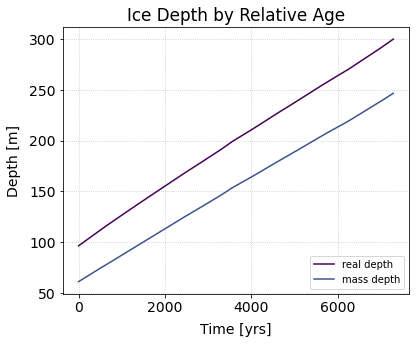

In [6]:
i_start = np.argmin(abs(depths_real-z_start))
i_end = np.argmin(abs(depths_real-z_deep))
z = depths_real[i_start:i_end+1]
h = z_to_h(z)
dh = z_to_h(depths_real[i_start+1:i_end+2]) - h
t = np.arange(len(z))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')

## Muon Energy Spectrum (from Models)

In [7]:
A_G = 0.14 #scale factor
gamma = 2.7 #index of energy spectrum
epsilon_pi = 115/1.1 #critical energy of pion (GeV)
epsilon_K = 850/1.1 #critical energy of kaon (GeV)
B_G = 0.054 # ratio factor between pion and kaon produced muons

def gaisser(E0, cosTH):
    # surface flux calculation
    Phi_G = A_G * E0**(-gamma) * (1/(1+E0*cosTH/epsilon_pi) + B_G/(1+E0*cosTH/epsilon_K))
    
    return Phi_G
    
def gaisser_tang(E0, cosTH):
    #cosTH_mod parameters
    p1 = 0.102573
    p2 = -0.068287
    p3 = 0.958633
    p4 = 0.0407253
    p5 = 0.817285
    
    #modified cosine to account for atmospheric curvature
    cosTH_mod = np.sqrt((cosTH**2 + p1**2 + p2*cosTH**p3 + p4*cosTH**p5)/(1+p1**2+p2+p4))
    
    #piecewise scale factor
    A_T = 1 * (E0 > 100/cosTH_mod) + 1.1 * (90 * np.sqrt(cosTH+0.001)/1030)**(4.5/(E0*cosTH_mod)) * (E0 <= 100/cosTH_mod)
    
    #proportion of prompt muons produced by the decay of charmed particles
    r_c = 10**(-4) * (E0 <= 100/cosTH_mod)
    
    E0_hat = E0 + 2.06e-3 * (950/cosTH_mod - 90)
    
    Phi_T = A_T * A_G * E0**(-gamma) * (1/(1+E0_hat*cosTH_mod/epsilon_pi) + B_G/(1+E0_hat*cosTH_mod/epsilon_K) + r_c)
    
    return Phi_T

In [8]:
def bugaev_reyna(E0, cosTH):
    A_B = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    y = np.log10(E0*cosTH)
    
    Phi_R = cosTH**3 * A_B * (E0*cosTH)**(-(a3*y**3 + a2*y**2 + a1*y + a0))
    
    return Phi_R

In [9]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [10]:
def judge_nash(E0, cosTH):
    H_pi = 114 #GeV
    H_K = 851 #GeV
    gamma_pi = 2.7
    gamma_K = gamma_pi
    A_pi = 0.28
    A_K = 0.0455
    y0 = 1000 # Atmosphere depth at sea level? (g/cm^2)
    r_pi = 0.76 #muon to parent pion energy ratio
    r_K = 0.523 #muon to parent kaon energy ratio
    q = 2.2e-3 #mean energy loss of the muon in the atmosphere (GeV cm^2/g)
    tau_mu = 2.2e-6 #mean muon lifetime (s)
    tau_pi = 2.61e-8 #mean pion lifetime (s)
    tau_K = 1.24e-8 #mean kaon lifetime (s)
    g = 981.3 #acceleration due to gravity (cm/s^2)
    R = 8.314e7 #gas constant (g cm^2/s^2 /K /mol)
    m_mu = 105.659e-3 #muon rest mass (GeV/c^2)
    m_pi = 139.580e-3 #pion rest mass (GeV/c^2)
    m_K = 493.800e-3 #kaon rest mass (GeV/c^2)
    c = 3e10 #speed of light (cm/s)
    M = 28.966 #effective molecular weight of air (g/mol)
    
    #effective mean temperature of the atmosphere as experienced at zenith angle theta
    T_e = 220 #220 #from Chatzidakis 2015
    
    H_mu = R*m_mu*T_e / c / M / g / tau_mu
    
    E_pi = (E0 + q*y0*(1/cosTH - 0.0874))/r_pi
    
    #H_pi = R*m_pi*c*T_e / M/g/tau_pi
    
    W_pi = (0.0874 * cosTH * (1- q * (y0/cosTH - 90)/r_pi/E_pi))**(H_mu/cosTH/(r_pi*E_pi+90*q))
    
    E_K = (E0 + q*y0*(1/cosTH - 0.0874))/r_K
    
    #H_K = R*m_K*c*T_e / M / g /tau_K
    
    W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))
    
    Phi_J = A_pi*W_pi*E_pi**(-gamma_pi)*H_pi / (E_pi*cosTH + H_pi) + A_K*W_K*E_K**(-gamma_K)*H_K / (E_K*cosTH + H_K)
    
    return Phi_J

In [11]:
def Heisinger(h):
    #parameters
    a = 7.6
    b = 321.7
    c = 8.059e-4
    d = 50.7
    e = 5.05e-5
    
    f = 0.846
    g = 0.015
    i = 0.003139
    
    # Heisinger's fit for average Energy
    E_pred = a + b * (1-np.exp(-c*h)) + d*(1-np.exp(-e*h))

    # Heisinger's Beta correction term
    Beta_pred = f - g*np.log(h+1)+i*np.log(h+1)**2
    
    return E_pred, Beta_pred

In [12]:
def deep_flux(E, cosTH, h, flux_func=gaisser): # project muon flux through ground
    #a = 0.227 #energy loss due to ionization (GeV cm^2/hg)
    #b = 2.44e-4 #sum of fractional radiation losses (cm^2/hg)
    E0 = (E + a/b)*np.exp(h*b/cosTH)-a/b #calculated surface energy
    dE0dE = np.exp(h*b/cosTH) #derivative of surface energy over energy at depth
    
    # estimated flux at depth h
    Phi = flux_func(E0, cosTH) * dE0dE
    
    return Phi

In [13]:
def flux_tot(E, cosTH, dcosTH, h, flux_func=gaisser): # integrate flux over solid angle
    
    Phi_tot = np.sum(deep_flux(E, cosTH, h, flux_func)*2*np.pi*dcosTH, axis=1)
    
    return Phi_tot

In [14]:
def avg_E(E, dE, Phi_tot, alpha=0.75): #Calculate average energy and cross section correction
    
    # calculate average Energy
    E_avg = np.sum(E[:,0]*Phi_tot*dE[:,0], axis=0)/np.sum(Phi_tot*dE[:,0], axis=0)
    
    # Calculate Beta correction term
    Ealph_avg = np.sum(E[:,0]**alpha * Phi_tot*dE[:,0], axis=0)/np.sum(Phi_tot*dE[:,0], axis=0)
    Beta = Ealph_avg / E_avg**alpha
    
    return E_avg, Beta

In [15]:
def avg_E_fast(E0, dE0, cosTH, dcosTH, h, flux_func=gaisser, alpha=0.75, alph190=True):
    #a, da = 0.227, 0 #energy loss due to ionization (GeV cm^2/hg)
    #b, db = 2.44e-4, 0 #sum of fractional radiation losses (cm^2/hg)
    E = ((E0 + a/b)*np.exp(-h*b/cosTH)-a/b).clip(min=0) #projected energy at depth
    E_safe = E.clip(min=1e-9) # E clipped so it's never 0 (no divide by 0 errors)
    
    f = flux_func(E0, cosTH)
    df = 0*f
    
    f_tot = np.sum((f*dcosTH*dE0)*(E>0), axis=(0,1))
    
    if alph190:
        Ealph190 = np.sum(((E_safe/190)**alpha * f * dcosTH * dE0)*(E>0), axis=(0,1))/f_tot
        return Ealph190
    
    E_avg = np.sum((E_safe * f * dcosTH * dE0)*(E>0), axis=(0,1))/f_tot
    Beta = np.sum((E_safe**alpha * f * dcosTH * dE0)*(E>0), axis=(0,1))/f_tot/E_avg**alpha
    
    return E_avg, Beta

$$\langle A \rangle = \frac{\int_0^1 \int_{\frac{a}{b}[e^{hb\sec\theta}-1]}^\infty A f(E_0, \cos\theta) dE_0 d\cos\theta}{\iint f dE_0 d\cos\theta}$$

$$\langle A \rangle = \frac{\int_0^1 \int_0^\infty A f(E_0(E), \cos\theta) e^{hb\sec\theta}dE\, d\cos\theta}{\iint f dE\, d\cos\theta}$$

In [16]:
# Setup Variables

# axis0 = Energy (GeV)
dEexp = 0.1
Eexp_min = -1
Eexp_max = 5

# axis1 = cosine of zenith angle (unitless)
dcosTH = 0.005
cosTH_min = dcosTH
cosTH_max = 1

# axis2 = mass depth (hg/cm^2)
dhexp = 0.1
hexp_min = 0
hexp_max = 4

# create 3D ogrid vectors
Eexp, cosTH, hexp = np.ogrid[Eexp_min:Eexp_max+dEexp:dEexp, cosTH_min:cosTH_max+dcosTH:dcosTH, hexp_min:hexp_max+dhexp:dhexp]

# generate log scaled E
E = 10**Eexp
dE = E * np.log(10) * dEexp

# generate log scaled h
h_test = 10**hexp
dh_test = h_test * np.log(10) * dhexp

C:\Users\walte\AppData\Local\Temp/ipykernel_12104/735983733.py:38: RuntimeWarning: invalid value encountered in power
  W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))


Text(0.5, 1.0, 'Surface Muon Flux by Energy')

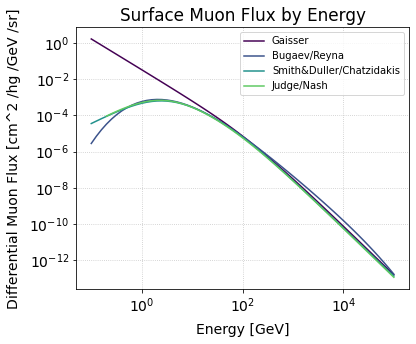

In [21]:
theta = 0 #degrees
costheta = np.cos(theta*np.pi/180)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(E[:,0,0], (gaisser(E, costheta) * dE)[:,0,0], label='Gaisser')
#ax.plot(E[:,0,0], (gaisser_tang(E, costheta) * dE)[:,0,0], label='Gaisser/Tang')
ax.plot(E[:,0,0], (bugaev_reyna(E, costheta) * dE)[:,0,0], label='Bugaev/Reyna')
ax.plot(E[:,0,0], (SDC(E, costheta) * dE)[:,0,0], label='Smith&Duller/Chatzidakis')
ax.plot(E[:,0,0], (judge_nash(E, costheta) * dE)[:,0,0], label='Judge/Nash')
ax.set(xscale = 'log',
       xlabel='Energy [GeV]',
       yscale = 'log',
       ylabel='Differential Muon Flux [cm^2 /hg /GeV /sr]')
ax.legend(loc='upper right', fontsize=10)
plt.title('Surface Muon Flux by Energy')

In [18]:
# calculate flux
Phi_G = flux_tot(E, cosTH, dcosTH, h_test, gaisser)
Phi_T = flux_tot(E, cosTH, dcosTH, h_test, gaisser_tang)
Phi_R = flux_tot(E, cosTH, dcosTH, h_test, bugaev_reyna)
Phi_S = flux_tot(E, cosTH, dcosTH, h_test, SDC)
Phi_J = flux_tot(E, cosTH, dcosTH, h_test, judge_nash)

Text(0.5, 1.0, 'Muon Flux per Energy, Mass Depth (Bugaev/Reyna)')

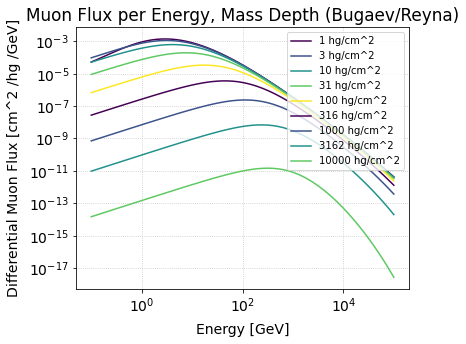

In [19]:
N = 9 #number of depths to plot
hi = np.linspace(0, len(h_test[0,0])-1, N, dtype=int) #indices of depths to be plotted

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
for i in hi:
    ax.plot(E[:,0,0], Phi_R[:,i]*dE[:,0,0], label='{} hg/cm^2'.format(int(h_test[0,0,i])))
ax.set(xscale = 'log',
       xlabel='Energy [GeV]',
       yscale = 'log',
       ylabel='Differential Muon Flux [cm^2 /hg /GeV]')
ax.legend(loc='upper right', fontsize=10)
plt.title('Muon Flux per Energy, Mass Depth (Bugaev/Reyna)')

In [20]:
alpha = 0.75 # Cross section energy dependence power

#Calculate average energies and cross-section correction
Eavg_G, Beta_G = avg_E(E, dE, Phi_G, alpha)
Eavg_T, Beta_T = avg_E(E, dE, Phi_T, alpha)
Eavg_R, Beta_R = avg_E(E, dE, Phi_R, alpha)
Eavg_S, Beta_S = avg_E(E, dE, Phi_S, alpha)
Eavg_J, Beta_J = avg_E(E, dE, Phi_J, alpha)

In [21]:
E_pred, Beta_pred = Heisinger(h_test[0,0])

Text(0.5, 1.0, 'Average Muon Energy over Depth')

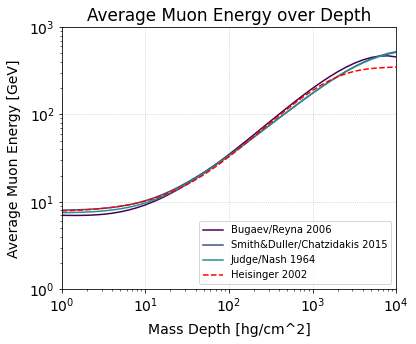

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
#ax.plot(h_test[0,0], Eavg_G, label='Gaisser')
#ax.plot(h_test[0,0], Eavg_T, label='Gaisser/Tang')
ax.plot(h_test[0,0], Eavg_R, label='Bugaev/Reyna 2006')
ax.plot(h_test[0,0], Eavg_S, label='Smith&Duller/Chatzidakis 2015')
ax.plot(h_test[0,0], Eavg_J, label='Judge/Nash 1964')
#ax.plot(h_test[0,0], avg_E_fast(E, dE, cosTH, dcosTH, h_test, judge_nash, alph190=False)[0], label='Judge/Nash fix')
ax.plot(h_test[0,0], E_pred, c='r', ls='--', label='Heisinger 2002')
ax.set(xlim = (1, 10000),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       ylim = (1,1000),
       yscale = 'log',
       ylabel='Average Muon Energy [GeV]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Average Muon Energy over Depth')

Text(0.5, 1.0, 'Energy Power Correction over Depth')

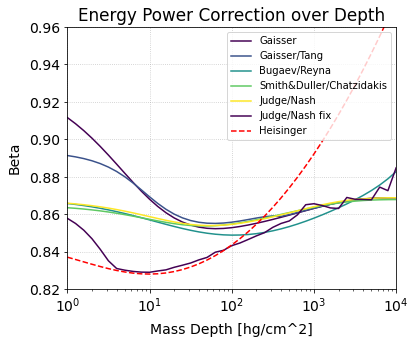

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], Beta_G, label='Gaisser')
ax.plot(h_test[0,0], Beta_T, label='Gaisser/Tang')
ax.plot(h_test[0,0], Beta_R, label='Bugaev/Reyna')
ax.plot(h_test[0,0], Beta_S, label='Smith&Duller/Chatzidakis')
ax.plot(h_test[0,0], Beta_J, label='Judge/Nash')
ax.plot(h_test[0,0], avg_E_fast(E, dE, cosTH, dcosTH, h_test, judge_nash, alph190=False)[1], label='Judge/Nash fix')
ax.plot(h_test[0,0], Beta_pred, c='r', ls='--', label='Heisinger')
ax.set(xlim = (1, 10000),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       ylim = (0.82,0.96),
       ylabel='Beta')
ax.legend(loc='upper right', fontsize=10)
plt.title('Energy Power Correction over Depth')

Text(0.5, 1.0, 'Cross Section Energy dependence over Depth')

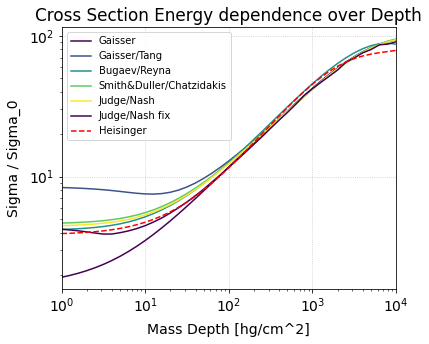

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], Beta_G*Eavg_G**alpha, label='Gaisser')
ax.plot(h_test[0,0], Beta_T*Eavg_T**alpha, label='Gaisser/Tang')
ax.plot(h_test[0,0], Beta_R*Eavg_R**alpha, label='Bugaev/Reyna')
ax.plot(h_test[0,0], Beta_S*Eavg_S**alpha, label='Smith&Duller/Chatzidakis')
ax.plot(h_test[0,0], Beta_J*Eavg_J**alpha, label='Judge/Nash')
ax.plot(h_test[0,0], avg_E_fast(E, dE, cosTH, dcosTH, h_test, judge_nash)*190**alpha, label='Judge/Nash fix')
ax.plot(h_test[0,0], Beta_pred*E_pred**alpha, c='r', ls='--', label='Heisinger')
ax.set(xlim = (1, 10000),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='Sigma / Sigma_0')
ax.legend(loc='upper left', fontsize=10)
plt.title('Cross Section Energy dependence over Depth')

## Muon Energy Spectrum (from Primary)

In [25]:
def E_deep(E0, cosTH, h):
    #a = 0.227 #energy loss due to ionization (GeV cm^2/hg)
    #b = 2.44e-4 #sum of fractional radiation losses (cm^2/hg)
    
    # axis0: particle
    # axis1: depth
    
    E0 = np.reshape(E0, (-1, 1))
    cosTH = np.reshape(cosTH, (-1, 1))
    h = np.reshape(h, (1,-1))
    
    E = (E0 + a/b)*np.exp(-h*b/cosTH)-a/b
    
    return E.clip(min=0)

In [26]:
def data(lgE, h, alpha=0.75, plot=False):
    hdus = fits.open('proton_fits/lgE_{:.1f}.fits'.format(lgE))
    
    E0 = hdus['ENERGY'].data
    cosTH = hdus['COSTH'].data
    
    if plot:
        Esp = np.logspace(-1,4,50)

        fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
        ax.hist(E0, bins=Esp)
        ax.set(xscale = 'log',
               xlabel='Energy [GeV]',
               #yscale='log',
               ylabel='count')
        plt.title('Muon Energy Spectrum from {:.2f} TeV proton'.format(10**(lgE-12)))
        
        yedge = np.linspace(0,1,30)
        xedge = np.linspace(-1,4,30)
        X = np.histogram2d(np.log10(E0), cosTH, bins=[xedge,yedge])[0]
        fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
        ax.imshow(X.T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
        ax.set(xlabel='log Energy [GeV]',
               #yscale='log',
               ylabel='cos theta')
        plt.title('Muon Energy Spectrum from {:.2f} TeV proton'.format(10**(lgE-12)))
        
        plt.show()
        
        return X
    
    E = E_deep(E0, cosTH, h)
    
    N = np.sum(E>0, axis=0)
    E_avg = np.sum(E**alpha *(E>0), axis=0)/N.clip(min=1)
    
    return [E_avg, N]

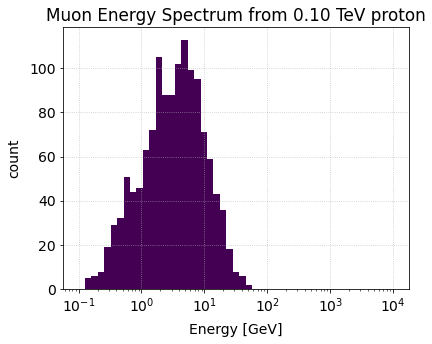

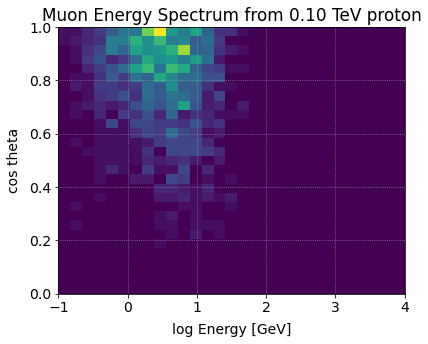

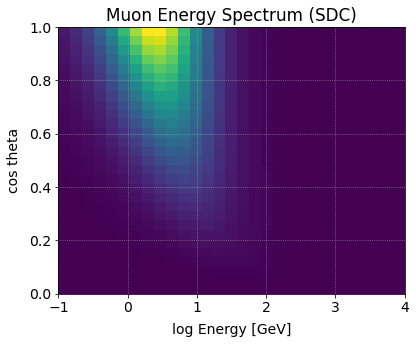

In [27]:
lgE = 11

X = data(lgE, [200], plot=True)

yedge = np.linspace(0,1,30)
xedge = np.linspace(-1,4,30)

E_plt = np.expand_dims(10**((xedge[:-1] + xedge[1:])/2), axis=1)
cos_plt = np.expand_dims((yedge[:-1] + yedge[1:])/2, axis=0)
Y = SDC(E_plt, cos_plt)*E_plt
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.imshow(Y.T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
ax.set(xlabel='log Energy [GeV]',
       #yscale='log',
       ylabel='cos theta')
plt.title('Muon Energy Spectrum (SDC)')
plt.show()

In [28]:
lgE_p = np.arange(11, 14.1, 0.1)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

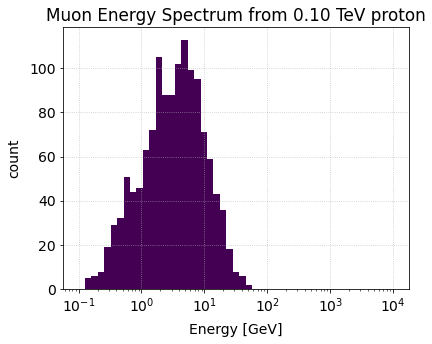

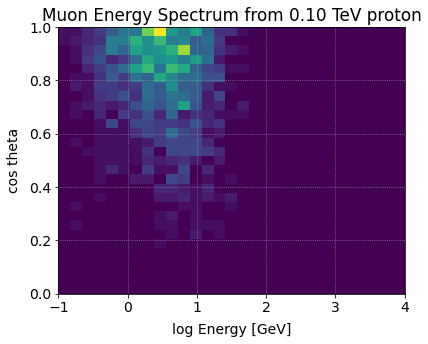

  3%|██▋                                                                                | 1/31 [00:00<00:10,  2.77it/s]

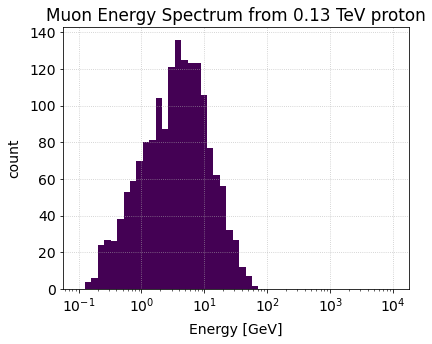

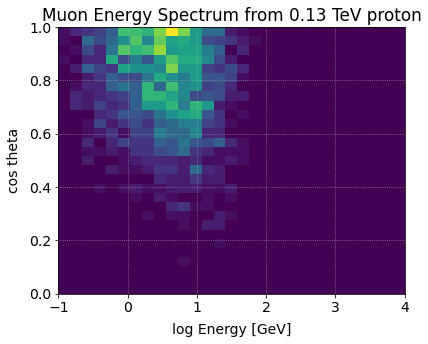

  6%|█████▎                                                                             | 2/31 [00:00<00:11,  2.50it/s]

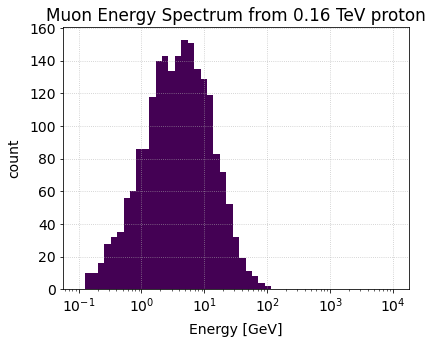

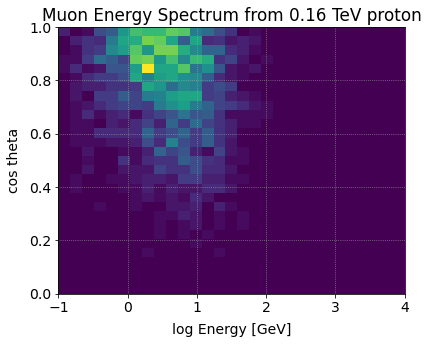

 10%|████████                                                                           | 3/31 [00:01<00:10,  2.55it/s]

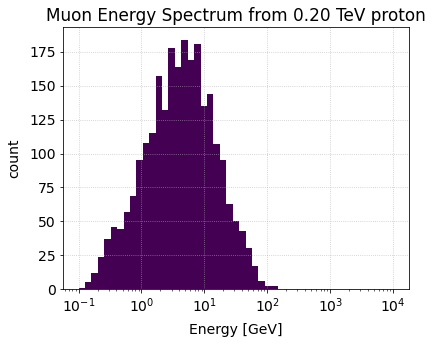

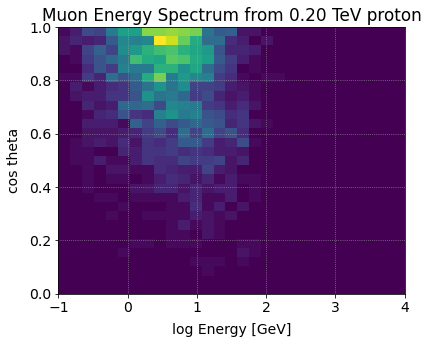

 13%|██████████▋                                                                        | 4/31 [00:01<00:10,  2.61it/s]

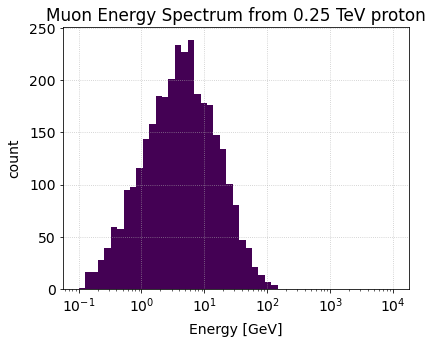

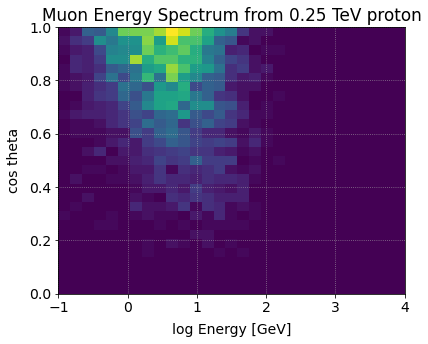

 16%|█████████████▍                                                                     | 5/31 [00:01<00:10,  2.47it/s]

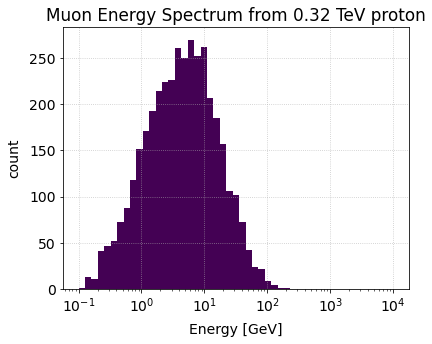

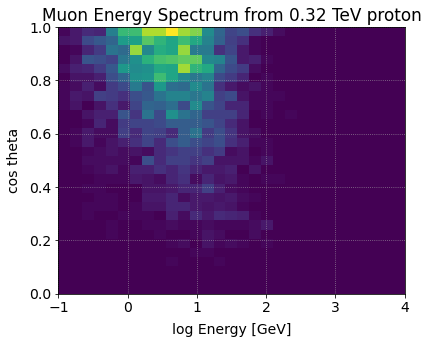

 19%|████████████████                                                                   | 6/31 [00:02<00:09,  2.50it/s]

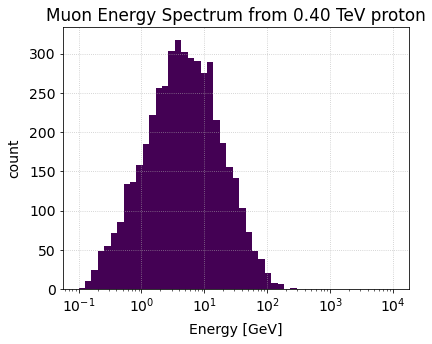

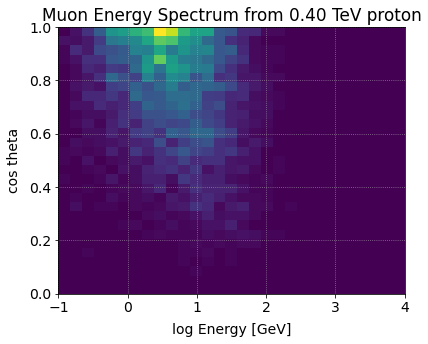

 23%|██████████████████▋                                                                | 7/31 [00:02<00:09,  2.52it/s]

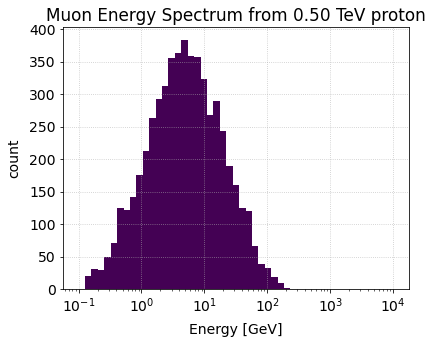

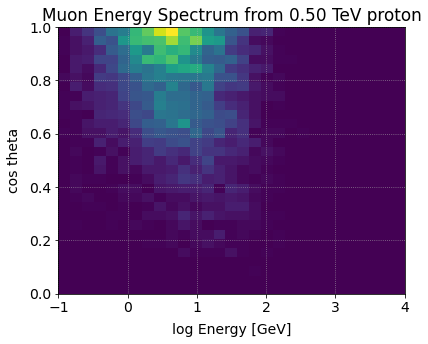

 26%|█████████████████████▍                                                             | 8/31 [00:03<00:09,  2.43it/s]

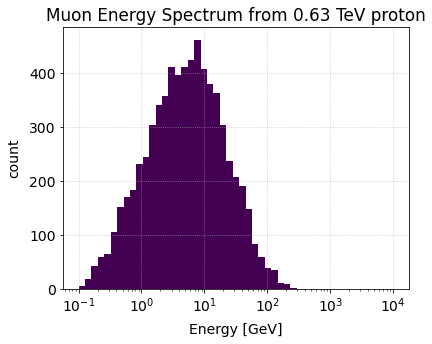

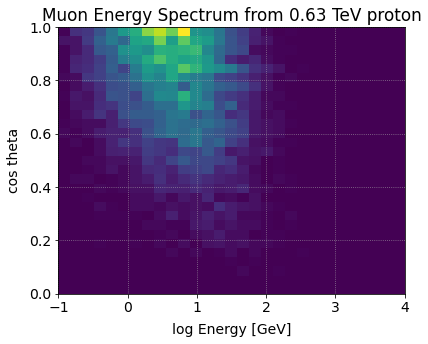

 29%|████████████████████████                                                           | 9/31 [00:03<00:08,  2.49it/s]

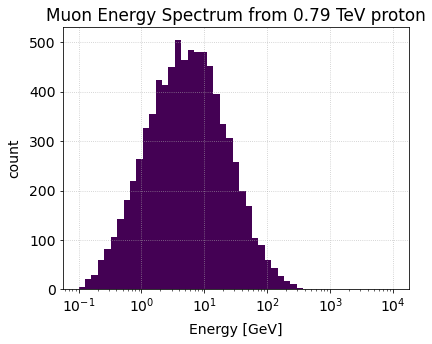

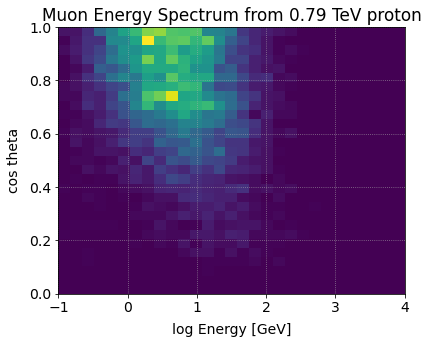

 32%|██████████████████████████▍                                                       | 10/31 [00:03<00:08,  2.53it/s]

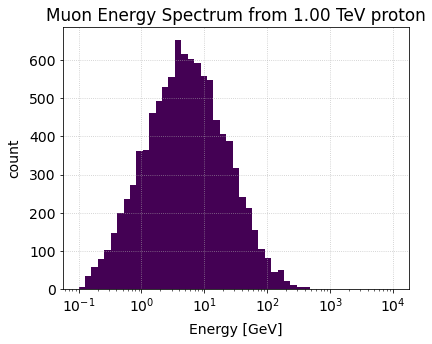

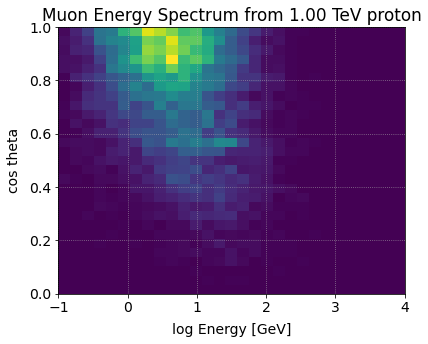

 35%|█████████████████████████████                                                     | 11/31 [00:04<00:08,  2.46it/s]

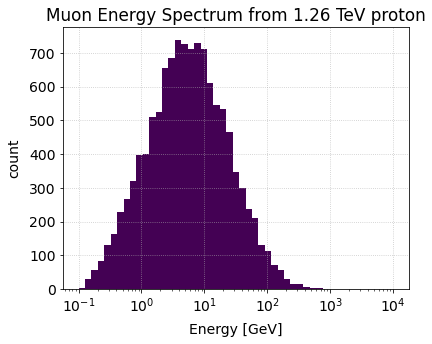

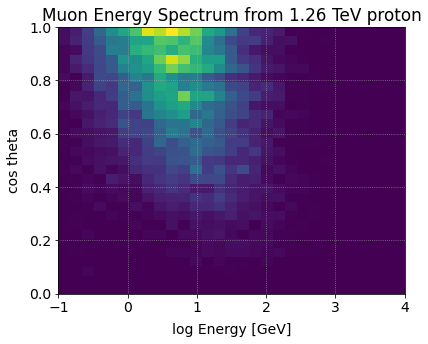

 39%|███████████████████████████████▋                                                  | 12/31 [00:04<00:07,  2.50it/s]

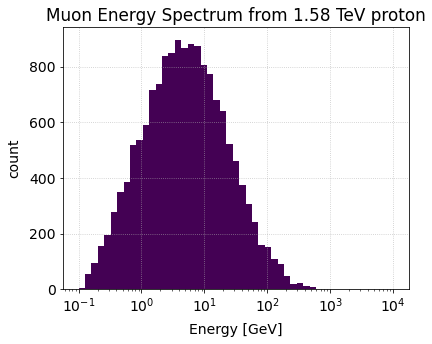

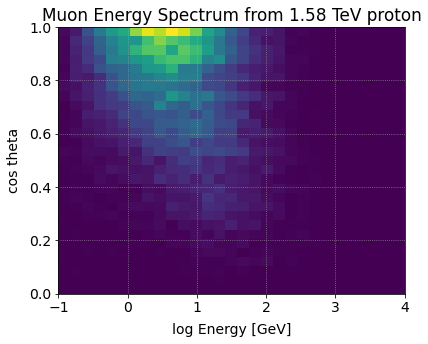

 42%|██████████████████████████████████▍                                               | 13/31 [00:05<00:07,  2.55it/s]

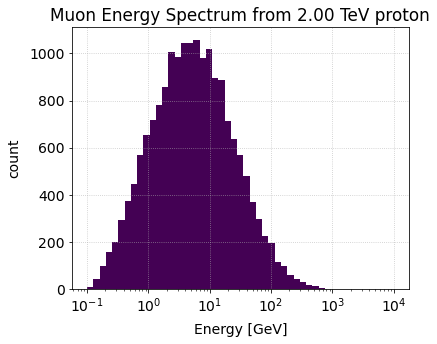

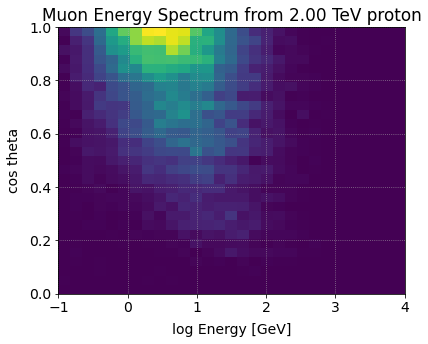

 45%|█████████████████████████████████████                                             | 14/31 [00:05<00:06,  2.46it/s]

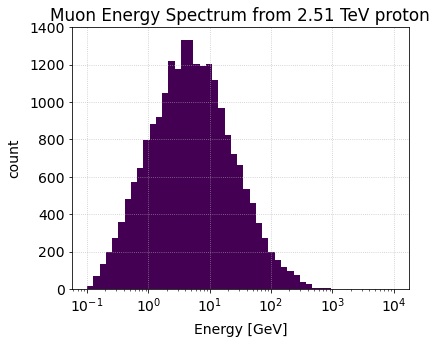

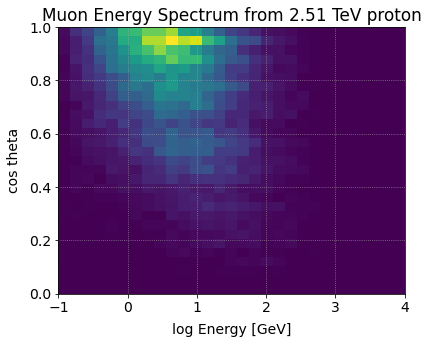

 48%|███████████████████████████████████████▋                                          | 15/31 [00:05<00:06,  2.51it/s]

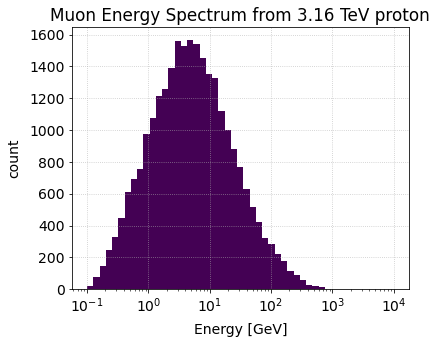

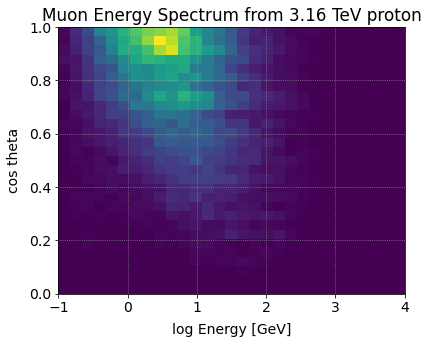

 52%|██████████████████████████████████████████▎                                       | 16/31 [00:06<00:05,  2.53it/s]

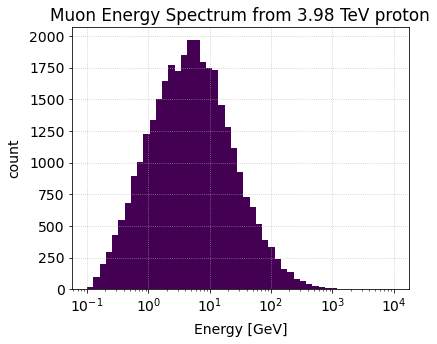

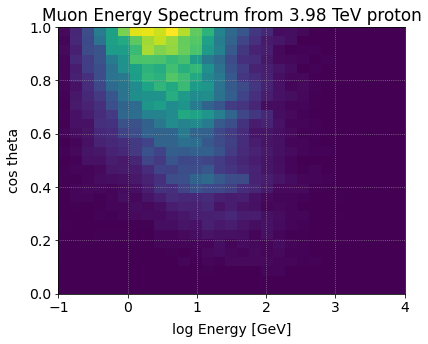

 55%|████████████████████████████████████████████▉                                     | 17/31 [00:06<00:05,  2.42it/s]

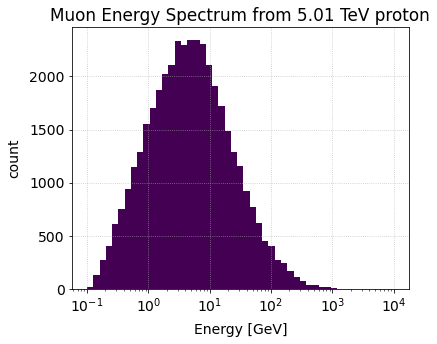

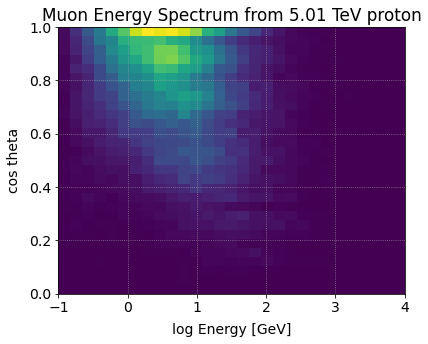

 58%|███████████████████████████████████████████████▌                                  | 18/31 [00:07<00:05,  2.49it/s]

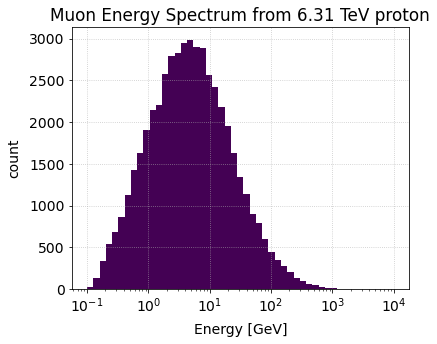

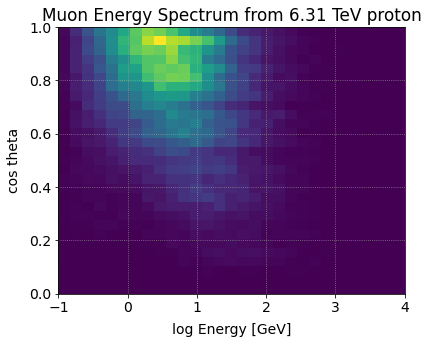

 61%|██████████████████████████████████████████████████▎                               | 19/31 [00:07<00:04,  2.52it/s]

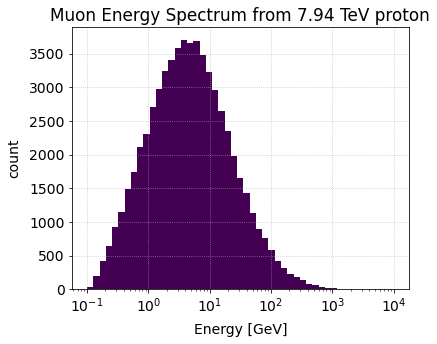

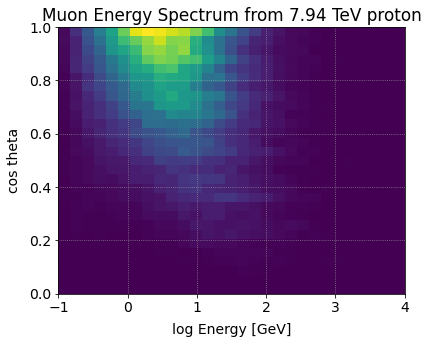

 65%|████████████████████████████████████████████████████▉                             | 20/31 [00:08<00:04,  2.42it/s]

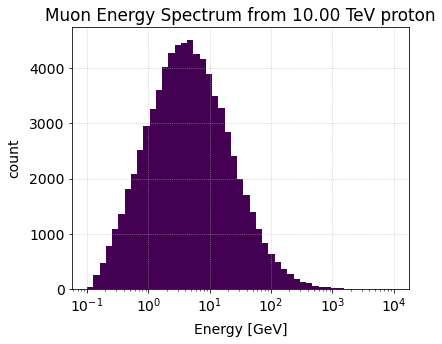

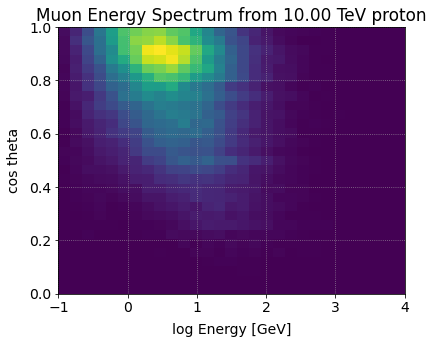

 68%|███████████████████████████████████████████████████████▌                          | 21/31 [00:08<00:04,  2.49it/s]

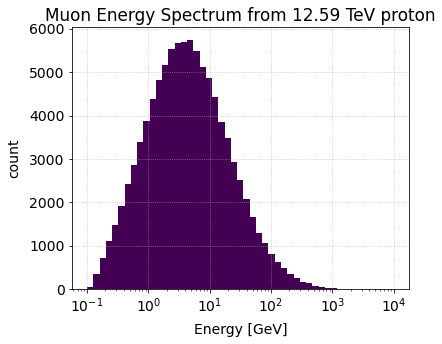

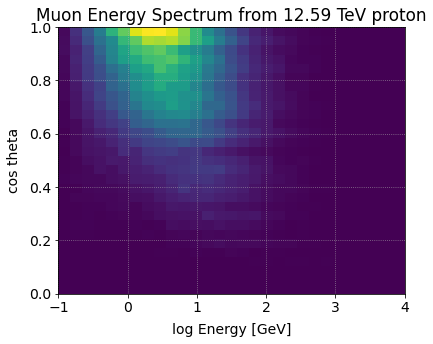

 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [00:08<00:03,  2.52it/s]

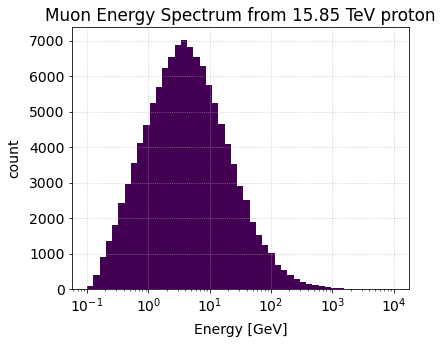

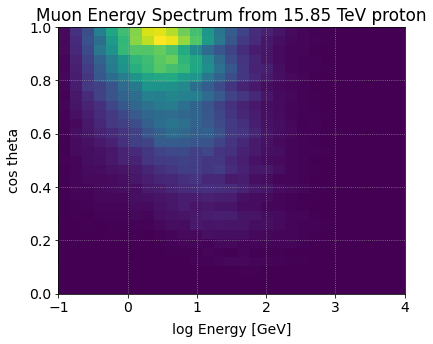

 74%|████████████████████████████████████████████████████████████▊                     | 23/31 [00:09<00:03,  2.40it/s]

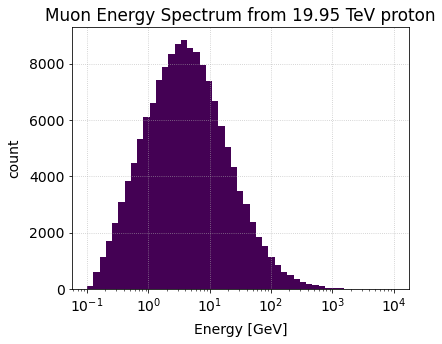

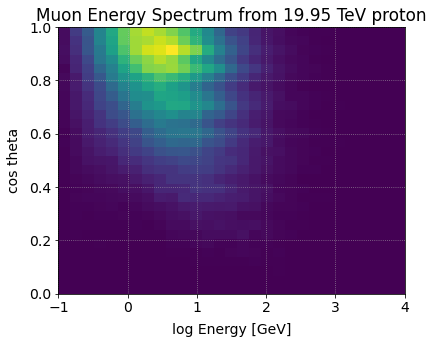

 77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [00:09<00:02,  2.45it/s]

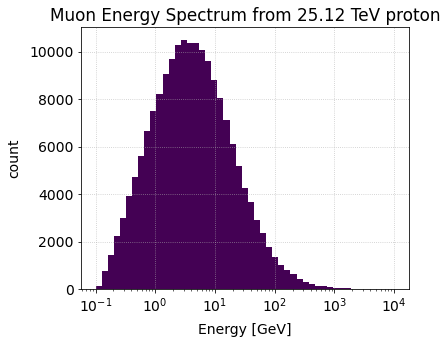

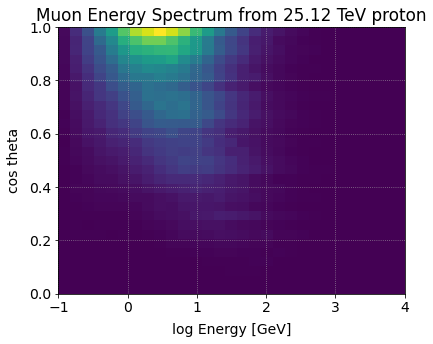

 81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [00:10<00:02,  2.46it/s]

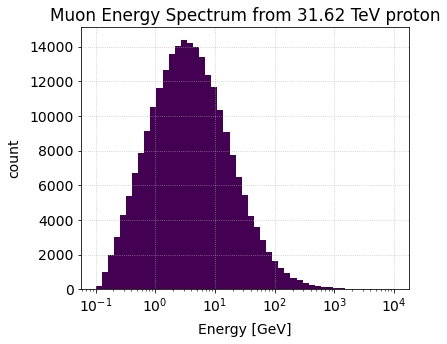

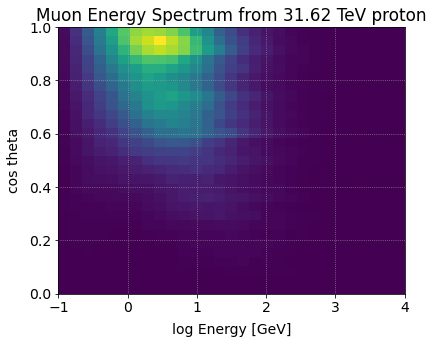

 84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [00:10<00:02,  2.30it/s]

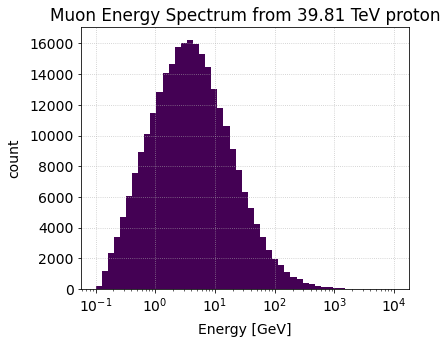

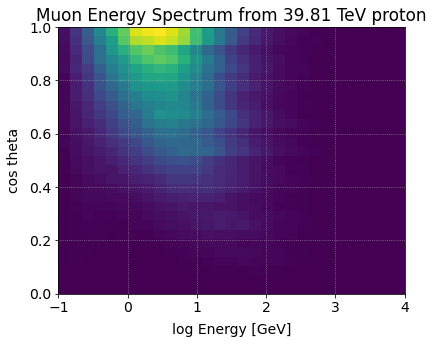

 87%|███████████████████████████████████████████████████████████████████████▍          | 27/31 [00:10<00:01,  2.32it/s]

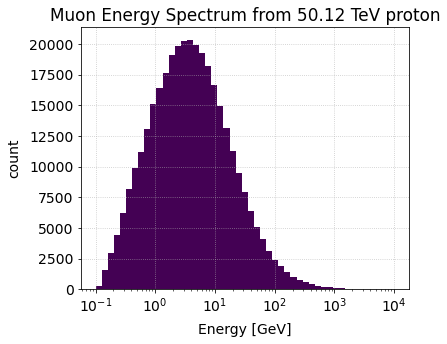

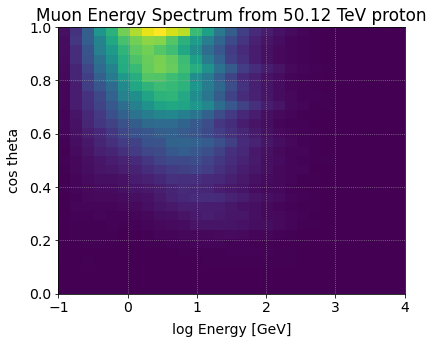

 90%|██████████████████████████████████████████████████████████████████████████        | 28/31 [00:11<00:01,  2.32it/s]

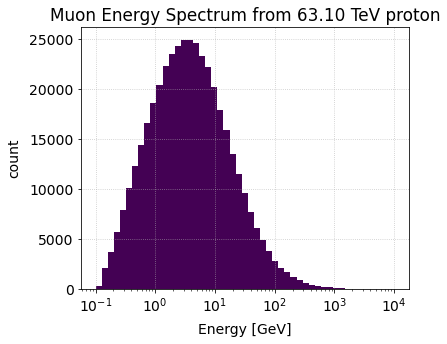

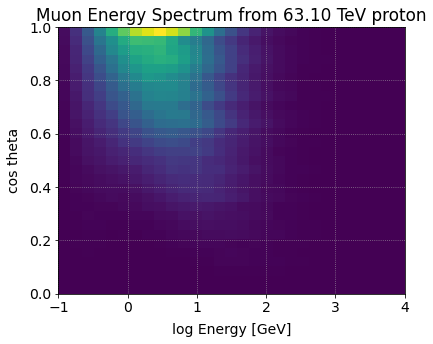

 94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [00:11<00:00,  2.21it/s]

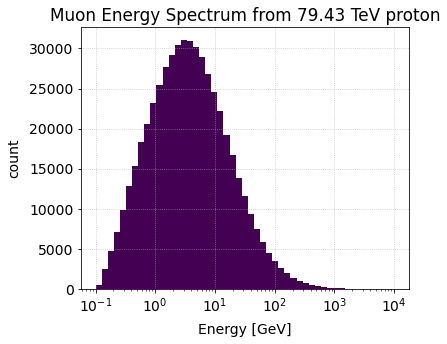

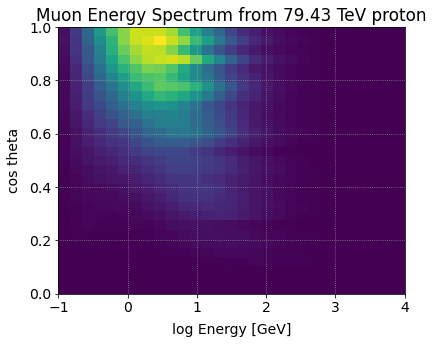

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [00:12<00:00,  2.15it/s]

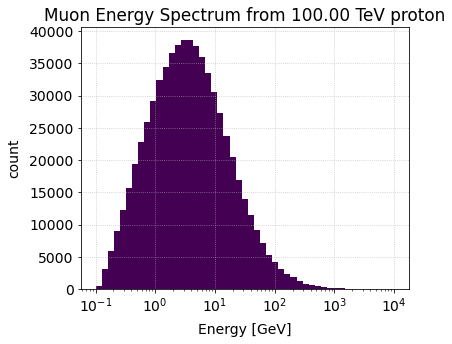

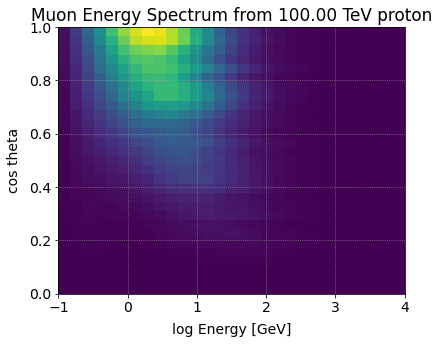

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:12<00:00,  2.41it/s]


In [29]:
Xs = np.array([data(lgE, [200], plot=True) for lgE in tqdm(lgE_p)])

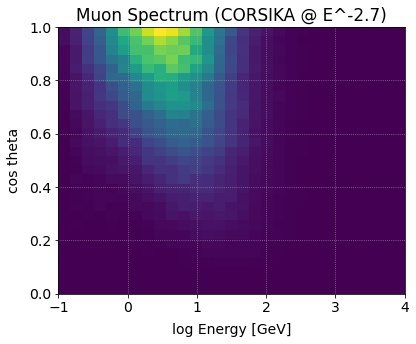

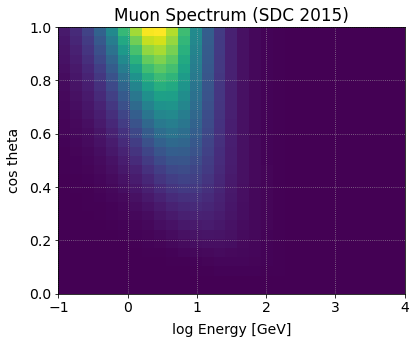

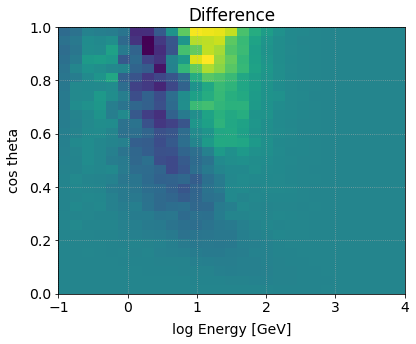

In [30]:
slope = -2.7
w = np.exp(lgE_p*slope)

yedge = np.linspace(0,1,30)
xedge = np.linspace(-1,4,30)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
X = np.average(Xs, weights=w, axis=0)
ax.imshow(X.T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
ax.set(xlabel='log Energy [GeV]',
        #yscale='log',
        ylabel='cos theta')
plt.title('Muon Spectrum (CORSIKA @ E^{:.1f})'.format(slope))

E_plt = np.expand_dims(10**((xedge[:-1] + xedge[1:])/2), axis=1)
cos_plt = np.expand_dims((yedge[:-1] + yedge[1:])/2, axis=0)
Y = SDC(E_plt, cos_plt)*E_plt
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.imshow(Y.T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
ax.set(xlabel='log Energy [GeV]',
        #yscale='log',
        ylabel='cos theta')
plt.title('Muon Spectrum (SDC 2015)')

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.imshow((X/np.sum(X)-Y/np.sum(Y)).T, extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], origin='lower', aspect='auto')
ax.set(xlabel='log Energy [GeV]',
        #yscale='log',
        ylabel='cos theta')
plt.title('Difference')
plt.show()

In [31]:
def new_calc(h, alpha=0.75):
    X = np.array([data(lgE, h, alpha) for lgE in tqdm(lgE_p)])

    E_avg_ps = X[:,0]
    N_ps = X[:,1]
    
    return E_avg_ps, N_ps

In [32]:
def save_calc(h, alpha=0.75):
    E_avg_ps, N_ps = new_calc(h, alpha)
    
    depthHDU = fits.PrimaryHDU(data=h)
    depthHDU.header['EXTNAME'] = 'DEPTH'
    depthHDU.header['BUNIT'] = 'hg/cm^2'

    energyHDU = fits.ImageHDU(data=E_avg_ps)
    energyHDU.header['EXTNAME'] = 'ENERGY FACTOR'
    energyHDU.header['BUNIT'] = 'GeV^0.75'
    
    nHDU = fits.ImageHDU(data=N_ps)
    nHDU.header['EXTNAME'] = 'COUNT'
    
    hdul = fits.HDUList([depthHDU, energyHDU, nHDU])

    outfile = 'proton_fits/avg_E^{:.2f}.fits'.format(alpha)
    hdul.writeto(outfile)
    
    return E_avg_ps, N_ps

In [33]:
def load_calc(alpha=0.75):
    hdus = fits.open('proton_fits/avg_E^{:.2f}.fits'.format(alpha))
    
    E_avg_ps = hdus['ENERGY FACTOR'].data
    N_ps = hdus['COUNT'].data
    
    return E_avg_ps, N_ps

In [34]:
E_avg_ps_test, N_ps_test = new_calc(h_test)
#E_avg_ps, N_ps = save_calc(h)
E_avg_ps, N_ps = load_calc()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.24it/s]


In [35]:
def E_pspect(E_avg_ps=E_avg_ps, N_ps=N_ps, N_E = 1+0*lgE_p):
    N_E = np.reshape(N_E, (-1, 1))
    
    return np.average(E_avg_ps, weights=N_ps*N_E, axis=0)

Text(0.5, 1.0, 'Average Cross Section Correction by Depth')

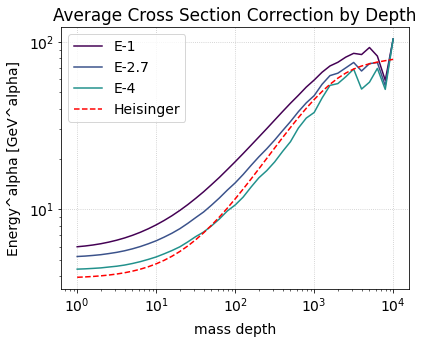

In [36]:
E_avg0 = E_pspect(E_avg_ps_test, N_ps_test, np.exp(-1*lgE_p))
E_avg1 = E_pspect(E_avg_ps_test, N_ps_test, np.exp(-2.7*lgE_p))
E_avg2 = E_pspect(E_avg_ps_test, N_ps_test, np.exp(-4*lgE_p))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], E_avg0, label='E-1')
ax.plot(h_test[0,0], E_avg1, label='E-2.7')
ax.plot(h_test[0,0], E_avg2, label='E-4')
ax.plot(h_test[0,0], Beta_pred*E_pred**alpha, c='r', ls='--', label='Heisinger')
ax.set(xlabel='mass depth',
       xscale='log',
       ylabel='Energy^alpha [GeV^alpha]',
       yscale='log')
ax.legend()
plt.title('Average Cross Section Correction by Depth')

Text(0.5, 1.0, 'Average Cross Section Correction by Depth')

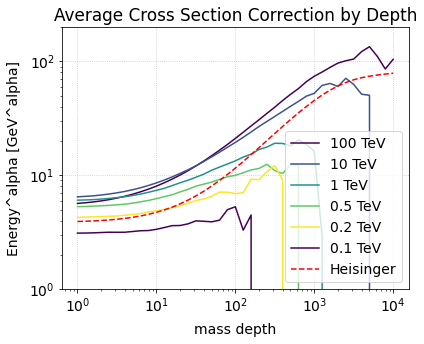

In [37]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], E_avg_ps_test[30], label='100 TeV')
ax.plot(h_test[0,0], E_avg_ps_test[20], label='10 TeV')
ax.plot(h_test[0,0], E_avg_ps_test[10], label='1 TeV')
ax.plot(h_test[0,0], E_avg_ps_test[7], label='0.5 TeV')
ax.plot(h_test[0,0], E_avg_ps_test[3], label='0.2 TeV')
ax.plot(h_test[0,0], E_avg_ps_test[0], label='0.1 TeV')
ax.plot(h_test[0,0], Beta_pred*E_pred**alpha, c='r', ls='--', label='Heisinger')
ax.set(xlabel='mass depth',
       xscale='log',
       ylabel='Energy^alpha [GeV^alpha]',
       ylim=(1,200),
       yscale='log')
ax.legend()
plt.title('Average Cross Section Correction by Depth')

## Attenuation Length

In [38]:
# Is this step calculating the average momentum for a given depth and finding the atmospheric attenuation length
# for that momentum?

# If Attenuation varies by momentum, shouldn't the energy spectrum change as a result?


#pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C

# figure the difference in atmospheric depth from sea level in g/cm2
#H = (1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# define range/momentum relation
# table for muons in standard rock in Groom and others 2001

# g/cm^2
#h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    #2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    #9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
#momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     #4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     #2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

def att_L(h):
    # effective atmospheric attenuation length for muons at mass depth h
    
    P_MeVc = np.exp(np.interp(np.log(h*100), np.log(h_range), np.log(momentum)))
    
    return 263 + 150 * P_MeVc/1000

Text(0.5, 1.0, 'Stopping Rate Correction over Depth')

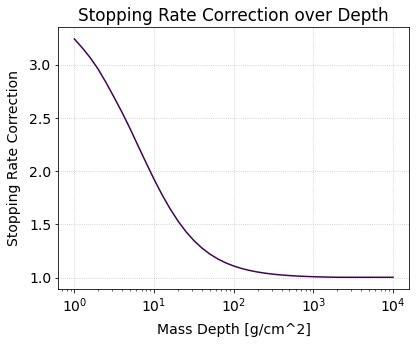

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], np.exp(H/att_L(h_test[0,0])))
ax.set(xlabel='Mass Depth [g/cm^2]',
       xscale='log',
       ylabel='Stopping Rate Correction')
plt.title('Stopping Rate Correction over Depth')

## Muon Flux & Stopping Rate

In [40]:
def phi_vert_slhl(h, p=p_vf):
    #parameters
    #p = [258.5,  #p0
        #-5.5e-4, #p1
        #210,     #p2
        #10,      #p3
        #1.66,    #p4
        #75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    Phi_v = p[0] * a / b / c  # cm^-2 s^-1 sr^-1
    
    return Phi_v

In [41]:
def R_vert_slhl(h, p=p_vf):
    #parameters
    #p = [258.5,  #p0
        #-5.5e-4, #p1
        #210,     #p2
        #10,      #p3
        #1.66,    #p4
        #75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    dadh = p[1] * a
    dbdh = 1.
    dcdh = p[4] * (h+p[3])**(p[4]-1)
    
    R_v = -p[0] * (b*c*dadh - a*c*dbdh - a*b*dcdh)/ b**2 / c**2  # hg^-1 s^-1 sr^-1
    
    return R_v

In [42]:
def phi_vert_site(h, dh, H=H, h_end=h_end):
    
    Phi_v= phi_vert_slhl(h)
    
    R_v = R_vert_slhl(h)
    
    R_site = R_v * np.exp(H/att_L(h))
    
    Phi_end = phi_vert_slhl(h_end)
    
    dh_ext = 1
    h_ext = np.arange(h[-1]+dh_ext, h_end+dh_ext, dh_ext)
    
    h_int = np.append(h, h_ext)
    dh_int = np.append(dh, dh_ext + 0*h_ext)
    
    R_int = R_vert_slhl(h_int) * np.exp(H/att_L(h_int))
    
    Phi_site = np.flip(np.cumsum(np.flip(R_int * dh_int))) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    Phi_site = Phi_site[:len(h)]
    
    #approximation where the exponential is almost constant in h
    #Phi_site = Phi_v * np.exp(H/att_L(h)) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    return Phi_site, R_site

In [43]:
def cos_pow(h, H=H, p=p_n):
    #parameters
    #p = [3.21,     #p0
         #0.297,    #p1
         #42,       #p2
         #1.21e-3]  #p3
    
    #H = (1013.25 - pressure/100) * 1.019716
    #h_mod = h + H (atmospheric depth diff. from sea level)
    
    # shouldn't H be subtracted here?
    
    n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)
    
    dndh = -p[1]/(h + H/100 + p[2]) + p[3]
    
    return n, dndh

In [44]:
def f_mu_neg(h = None):
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]
    
    return 1/(K_mu+1)

In [45]:
def phi_all(h, dh, H=H, cos_pow_func=cos_pow, f_func=f_mu_neg):
    
    n, dndh = cos_pow_func(h, H)
    
    Phi_v, R_v = phi_vert_site(h, dh, H)
    
    Phi = 2*np.pi/(n+1) * Phi_v
    
    R = f_func(h) * (2*np.pi * R_v + Phi*dndh) / (n+1)
    
    return Phi, R # cm^-2 s^-1

In [46]:
Phi_v = phi_vert_slhl(h_test[0,0])
R_v = R_vert_slhl(h_test[0,0])
Phi_site, R_site = phi_vert_site(h_test[0,0], dh_test[0,0], H=H)

Text(0.5, 1.0, 'Vertical Muon Flux over Depth')

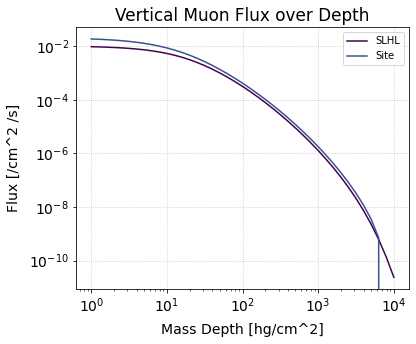

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], Phi_v, label='SLHL')
ax.plot(h_test[0,0], Phi_site, label='Site')
ax.set(xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale='log',
       ylabel='Flux [/cm^2 /s]')
ax.legend(loc='upper right', fontsize=10)
plt.title('Vertical Muon Flux over Depth')

Text(0.5, 1.0, 'Vertical Muon Stopping Rate over Depth')

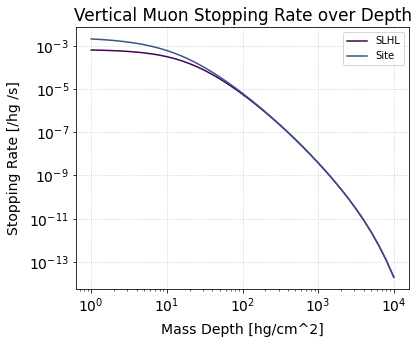

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], R_v, label='SLHL')
ax.plot(h_test[0,0], R_site, label='Site')
ax.set(xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='Stopping Rate [/hg /s]')
ax.legend(loc='upper right', fontsize=10)
plt.title('Vertical Muon Stopping Rate over Depth')

In [49]:
Phi, R = phi_all(h_test[0,0], dh_test[0,0])
Phi0, R0 = phi_all(h_test[0,0], dh_test[0,0], H=0)

Text(0.5, 1.0, 'Muon Flux over Depth')

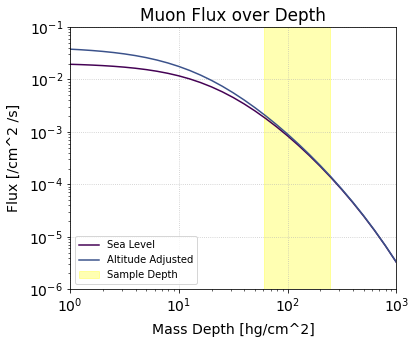

In [50]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[0], h[-1], color='yellow', alpha=0.3, label='Sample Depth')
ax.plot(h_test[0,0], Phi0, label='Sea Level')
ax.plot(h_test[0,0], Phi, label='Altitude Adjusted')
ax.set(xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       xlim = (1,1000),
       yscale = 'log',
       ylim = (1e-6,1e-1),
       ylabel='Flux [/cm^2 /s]')
ax.legend(loc='lower left', fontsize=10)
plt.title('Muon Flux over Depth')

Text(0.5, 1.0, 'Negative Muon Stopping Rate over Depth')

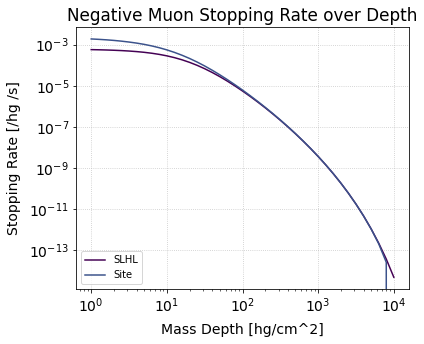

In [51]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], R0, label='SLHL')
ax.plot(h_test[0,0], R, label='Site')
ax.set(xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='Stopping Rate [/hg /s]')
ax.legend(loc='lower left', fontsize=10)
plt.title('Negative Muon Stopping Rate over Depth')

In [52]:
n = cos_pow(h_test[0,0], H)[0]
n0 = cos_pow(h_test[0,0], 0)[0]

Text(0.5, 1.0, 'Cosine power over Depth')

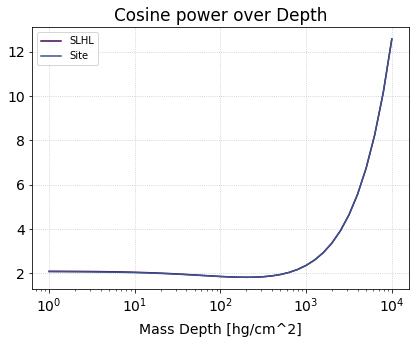

In [53]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(h_test[0,0], n0, label='SLHL')
ax.plot(h_test[0,0], n, label='Site')
ax.set(xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]')
ax.legend(loc='upper left', fontsize=10)
plt.title('Cosine power over Depth')

## Production Rates

In [54]:
def P_rates(h=h, dh=dh, H=H, E_func=judge_nash, fix=True, alpha=alpha, slope=slope):
    
    #f_C, df_C = 1, 0 # value should be absolute
    #f_D, df_D = 0.1828, 0 #error unknown
    #f_star, df_star = 0.137, 0.011
    
    #sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
    #alpha = 0.75
    sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
    N = 6.022e23 / 0.1802 # hg^-1
    
    if E_func==Heisinger:
        E_avg, Beta = Heisinger(h)
        
        sigma = sigma_0 * E_avg**alpha * Beta
    elif E_func==E_pspect:
        Ealph_avg = E_pspect(N_E = np.exp(slope*lgE_p))
        
        sigma = sigma_0 * Ealph_avg
    else:
        # Setup Integration Variables

        # axis0 = Energy (GeV)
        dEexp = 0.05
        Eexp_min = 0
        Eexp_max = 4

        # axis1 = cosine of zenith angle (unitless)
        dcosTH = 0.005
        cosTH_min = dcosTH
        cosTH_max = 1

        # create 2D ogrid vectors
        Eexp, cosTH = np.ogrid[Eexp_min:Eexp_max+dEexp:dEexp, cosTH_min:cosTH_max+dcosTH:dcosTH]

        # generate log scaled E
        E = np.expand_dims(10**Eexp, axis=2)
        dE = E * np.log(10) * dEexp

        cosTH = np.expand_dims(cosTH, axis=2)

        # axis2 = mass depth (hg/cm^2)
        h_3d = np.reshape(h, (1,1,-1))
        
        if fix:
            Ealph190 = avg_E_fast(E, dE, cosTH, dcosTH, h_3d, E_func, alpha) # GeV, unitless
            
            sigma = sigma_190 * Ealph190
            #dsigma = np.sqrt((Ealph190 * dsigma_190)**2 + (sigma_190 * dEalph190)**2)
            #print(dEalph190/Ealph190)
            #print(dsigma/sigma)
        else:
            Phi_E = flux_tot(E, cosTH, dcosTH, h_3d, flux_func=E_func) # cm^-2 GeV^-1 s^-1
            E_avg, Beta = avg_E(E, dE, Phi_E, alpha) # GeV, unitless
            
            sigma = sigma_0 * E_avg**alpha * Beta
    
    Phi, R = phi_all(h, dh, H) # hg^-1 s^-1
    
    P_neg = R * f_C * f_D * f_star
    #dP_neg = np.sqrt((dR*f_C*f_D*f_star)**2 + (R*df_C*f_D*f_star)**2 + (R*f_C*df_D*f_star)**2 + (R*f_C*f_D*df_star)**2)
    
    P_fast = sigma * Phi * N
    #dP_fast = np.sqrt((dsigma * Phi * N)**2 + (sigma * dPhi * N)**2 + (sigma * Phi * dN)**2)
    
    return np.array([P_neg, P_fast]) /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1

In [55]:
P_neg, P_fast = P_rates(E_func=Heisinger, H=0) # g^-1 a^-1

In [56]:
P_neg_H, P_fast_H = P_rates(E_func=Heisinger) # g^-1 a^-1

In [57]:
P_neg_S, P_fast_S = P_rates(E_func=SDC, fix=False) # g^-1 a^-1

In [58]:
P_neg_F, P_fast_F = P_rates(E_func=SDC, fix=True) # g^-1 a^-1

In [59]:
P_neg_P, P_fast_P = P_rates(E_func=E_pspect) # g^-1 a^-1

Text(0.5, 1.0, 'In Situ 14CO Production Rates over Depth')

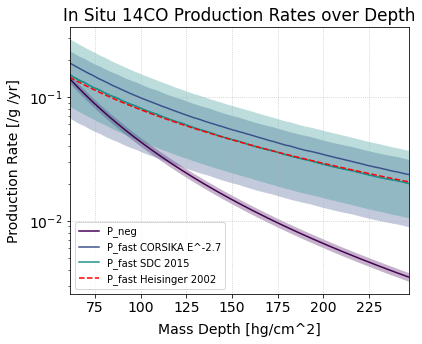

In [60]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.fill_between(h, P_neg*(1 + df_star/f_star), P_neg*(1 - df_star/f_star), alpha=0.3)
ax.fill_between(h, P_fast_F*(1+dsigma_190/sigma_190), P_fast_F*(1-dsigma_190/sigma_190), alpha=0.3)
ax.fill_between(h, P_fast_P*(1+dsigma_190/sigma_190), P_fast_P*(1-dsigma_190/sigma_190), alpha=0.3)

#ax.plot(h, P_neg*0.068+P_fast*0.072, label='total')
ax.plot(h, P_neg, label='P_neg')
#ax.plot(h, P_fast*0.072, label='P_fast Heisinger @ SLHL')

#ax.plot(h, P_neg_S*0.068+P_fast_S*0.072, label='SDC dE total')
#ax.plot(h, P_fast_S*0.072, label='P_fast SDC old')

#ax.plot(h, P_neg_F*0.068+P_fast_F*0.072, label='SDC dE0 total')
ax.plot(h, P_fast_P, label='P_fast CORSIKA E^-2.7')
ax.plot(h, P_fast_F, label='P_fast SDC 2015')


ax.plot(h, P_fast_H, c='r', ls='--', label='P_fast Heisinger 2002')
ax.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (h[0], h[-1]),
       yscale = 'log',
       ylabel='Production Rate [/g /yr]')
ax.legend(loc='lower left', fontsize=10)
plt.title('In Situ 14CO Production Rates over Depth')

### Production Rate Uncertainties

\begin{align*}
    \frac{\partial P_{\text{fast}}(h)}{\partial f(E_0)} &= \frac{P_{\text{fast}}}{\langle E^\alpha \rangle} \frac{\langle E(E_0)^\alpha \rangle_\theta - \langle E^\alpha \rangle}{f_{\text{all}}}dE_0; \quad E_0 > \frac{a}{b}[e^{hb/\cos\theta}-1]\\
    \frac{\partial P_{\text{fast}}(h)}{\partial a} &= \frac{P_{\text{fast}}}{\langle E^\alpha \rangle} \frac{\alpha}{b} \langle E^{\alpha-1} [e^{-hb/\cos\theta} - 1] \rangle\\
    \frac{\partial P_{\text{fast}}(h)}{\partial b} &= \frac{P_{\text{fast}}}{\langle E^\alpha \rangle} \alpha \langle E^{\alpha-1} [(\frac{h}{\cos\theta}(E_0 + \frac{a}{b}) + \frac{a}{b^2})e^{-hb/\cos\theta} + \frac{a}{b^2}]\rangle\\
    \frac{\partial P_{\text{fast}}(h)}{\partial \alpha} &= \frac{P_{\text{fast}}}{\langle E^\alpha \rangle} \langle E^{\alpha} \ln\frac{E}{190 \text{ GeV}} \rangle\\
    \frac{\partial P_{\text{fast}}(h)}{\partial \sigma_{190}} &= \frac{P_{\text{fast}}}{\sigma_{190}}\\
    \frac{\partial P_{\text{fast}}(h)}{\partial R_v(h')} &= \frac{P_{\text{fast}}}{\phi_{vs}} e^{H/L(h')} dh'; \quad h < h' < h_f \\
    \frac{\partial P_{\text{fast}}(h)}{\partial H} &= P_{\text{fast}} [\frac{1}{\phi_{vs}} \int_h^{hf}\frac{1}{L(h')}R_v(h') e^{H/L(h')}\, dh' - \frac{1}{100}\frac{dn/dh}{n+1}]\\
    \frac{\partial P_{\text{fast}}(h)}{\partial n(h)} &= -\frac{P_{\text{fast}}}{n+1}\\
    \frac{\partial P_{\text{fast}}(h)}{\partial N} &= \frac{P_{\text{fast}}}{N}
\end{align*}

\begin{align*}
    \frac{\partial P_{\text{neg}}(h)}{\partial R_v(h')} &= \frac{P_{\text{neg}}}{R} f_{\mu-}\frac{2\pi}{n+1}[\delta(h'-h) + \frac{dn/dh}{n+1}]e^{H/L(h)} dh'; \quad h \leq h' < h_f\\
    \frac{\partial P_{\text{neg}}(h)}{\partial n(h)} &= -\frac{P_{\text{neg}}}{n+1}[1+f_{\mu-}\frac{\Phi_{\text{tot}}}{R}\frac{dn/dh}{n+1}]\\
    \frac{\partial P_{\text{neg}}(h)}{\partial n'(h)} &= \frac{P_{\text{neg}}}{R} \frac{f_{\mu-}}{n+1}\Phi_{\text{tot}}\\
    \frac{\partial P_{\text{neg}}(h)}{\partial K_\mu} &= -\frac{P_{\text{neg}}}{K_\mu+1}\\
    \frac{\partial P_{\text{neg}}(h)}{\partial f_C} &= \frac{P_{\text{neg}}(h)}{f_C}\\
    \frac{\partial P_{\text{neg}}(h)}{\partial f_D} &= \frac{P_{\text{neg}}(h)}{f_D}\\
    \frac{\partial P_{\text{neg}}(h)}{\partial f^*} &= \frac{P_{\text{neg}}(h)}{f^*}\\
\end{align*}

## Integration

In [61]:
def roll_zeros(x, shift): #roll array and zero out values which go out of bounds; shift>0
    y = np.roll(x, shift)
    y[:shift] = 0
    return y

In [62]:
def M_conv(P):
    # axis0 = production mode
    # axis1 = time (present -> past)
    # axis2 = depth
    P_out = np.array([[roll_zeros(p, i) for i in range(len(p))] for p in P])
    
    # axis0 = production mode
    # axis1 = depth
    # axis2 = time
    P_out = np.swapaxes(P_out, 1, 2)
    
    # axis2 = time (past -> present)
    P_out = np.flip(P_out, axis=2)
    
    return P_out

In [63]:
def decay_matrix(t, lambd=lambd):
    return np.expand_dims(np.diag((1-lambd)**(t[-1]-t)), axis=0)

In [64]:
def f_const(t, f_neg = f_neg, f_fast=f_fast):
    
    return 0*t + f_neg, 0*t + f_fast

In [65]:
def f_all(t, f_func = f_const):
    
    f_neg, f_fast = f_func(t)
    
    return np.expand_dims([f_neg, f_fast], axis=2)

In [66]:
P0 = M_conv(np.array([P_neg, P_fast]))

In [67]:
PH = M_conv(np.array([P_neg_H, P_fast_H]))

In [68]:
PS = M_conv(np.array([P_neg_S, P_fast_S]))

In [69]:
PF = M_conv(np.array([P_neg_F, P_fast_F]))

In [70]:
PP = M_conv(np.array([P_neg_P, P_fast_P]))

In [71]:
L = decay_matrix(t)

In [72]:
f = f_all(t)

In [73]:
CO0 = (P0 @ (L @ f))[:,:,0]
COH = (PH @ (L @ f))[:,:,0]
COS = (PS @ (L @ f))[:,:,0]
COF = (PF @ (L @ f))[:,:,0]
COP = (PP @ (L @ f))[:,:,0]

Text(0.5, 1.0, 'In Situ 14CO Concentration over Depth')

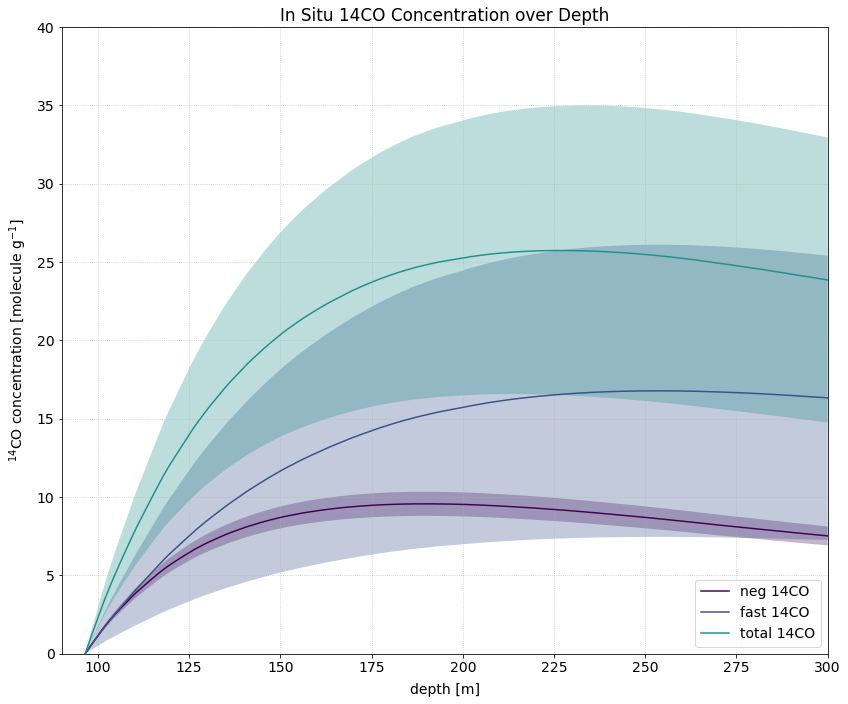

In [74]:
fig, ax = plt.subplots(1,1, figsize=(12,10), tight_layout=True)
ax.fill_between(z, COH[0]*(1+df_star/f_star), COH[0]*(1-df_star/f_star), alpha=0.3)
ax.fill_between(z, COH[1]*(1+dsigma_190/sigma_190), COH[1]*(1-dsigma_190/sigma_190), alpha=0.3)

COH_err = np.sqrt((COH[1]*(dsigma_190/sigma_190))**2 + (COH[0]*(df_star/f_star))**2)
ax.fill_between(z, np.sum(COH, axis=0)+COH_err, np.sum(COH, axis=0)-COH_err, alpha=0.3)

ax.plot(z, COH[0], label='neg 14CO')
ax.plot(z, COH[1], label='fast 14CO')
ax.plot(z, np.sum(COH, axis=0), label='total 14CO')

ax.set(xlim=(90,300),
       xlabel='depth [m]',
       ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=14)
plt.title('In Situ 14CO Concentration over Depth')

Text(0.5, 1.0, 'In Situ 14CO Concentration over Depth')

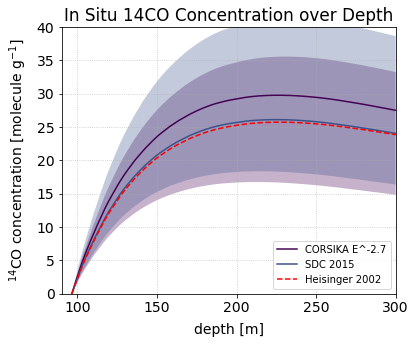

In [75]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
COF_err = np.sqrt((COF[1]*(dsigma_190/sigma_190))**2 + (COF[0]*(df_star/f_star))**2)
ax.fill_between(z, np.sum(COF, axis=0)+COF_err, np.sum(COF, axis=0)-COF_err, alpha=0.3)

COP_err = np.sqrt((COP[1]*(dsigma_190/sigma_190))**2 + (COP[0]*(df_star/f_star))**2)
ax.fill_between(z, np.sum(COP, axis=0)+COP_err, np.sum(COP, axis=0)-COP_err, alpha=0.3)

#ax.plot(z, np.sum(CO0, axis=0), label='14CO Heisinger @ SLHL')
#ax.plot(z, np.sum(COS, axis=0), label='14CO SDC int dE')

ax.plot(z, np.sum(COP, axis=0), label='CORSIKA E^-2.7')
ax.plot(z, np.sum(COF, axis=0), label='SDC 2015')

ax.plot(z, np.sum(COH, axis=0), c='r', ls='--', label='Heisinger 2002')
ax.set(xlim=(90,300),
       xlabel='depth [m]',
       ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('In Situ 14CO Concentration over Depth')

In [76]:
mu_neg_file, mu_fast_file = '../Dome-C/models/balco_14co_delta_neg_models.fits', '../Dome-C/models/balco_14co_delta_fast_models.fits'

In [77]:
hdus_neg = fits.open(mu_neg_file)

# Set up mu_neg 14CO profiles.
z_neg = hdus_neg['DEPTH'].data
co14_neg = hdus_neg['CO14'].data
t_spike_neg = hdus_neg['T_SPIKE'].data['T_SPIKE']

order = np.argsort(-t_spike_neg)

z_fits = z_neg
t_fits = np.array(t_spike_neg[order])
CO_neg = np.array(co14_neg[order])[:,1:]


hdus_fast = fits.open(mu_fast_file)

# Set up mu_fast 14CO profiles.
z_fast = hdus_fast['DEPTH'].data
co14_fast = hdus_fast['CO14'].data
t_spike_fast = hdus_fast['T_SPIKE'].data['T_SPIKE']

order = np.argsort(-t_spike_fast)

# axis0 = time, axis1 = depth
CO_fast = np.array(co14_fast[order])[:,1:]

Text(0.5, 1.0, 'Negative Muon Capture Production Rate')

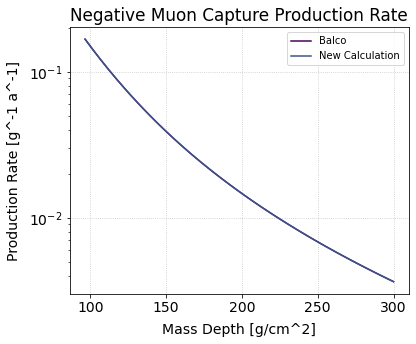

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z_fits[1:], CO_neg[0], label='Balco')
#plt.plot(z, np.log(P0[0,:,-1]))
ax.plot(z, PS[0,:,-1], label='New Calculation')
ax.set(xlabel='Mass Depth [g/cm^2]',
       ylabel='Production Rate [g^-1 a^-1]',
       yscale='log')
ax.legend(loc='upper right', fontsize=10)
plt.title('Negative Muon Capture Production Rate')

Text(0.5, 1.0, 'Fast Muon Production Rate')

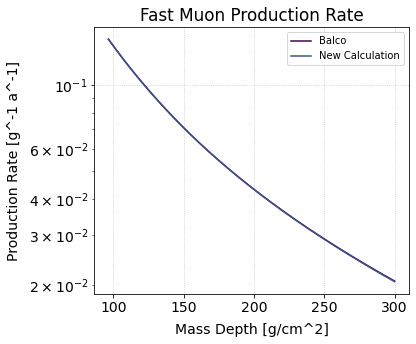

In [79]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z_fits[1:], CO_fast[0], label='Balco')
ax.plot(z, PH[1,:,-1], label='New Calculation')
ax.set(xlabel='Mass Depth [g/cm^2]',
       ylabel='Production Rate [g^-1 a^-1]',
       yscale='log')
ax.legend(loc='upper right', fontsize=10)
plt.title('Fast Muon Production Rate')

Text(0.5, 1.0, '14CO Constant Profile')

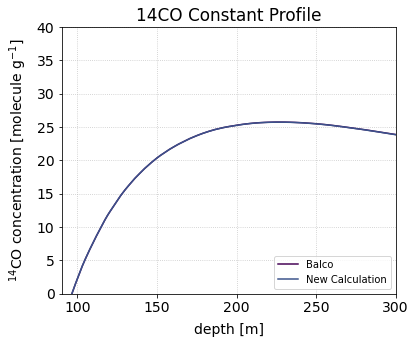

In [80]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z_fits[1:], (CO_neg.T @ np.flip(f[0,1:,0])) + (CO_fast.T @ np.flip(f[1,1:,0])), label='Balco')
ax.plot(z, np.sum(COH, axis=0), label='New Calculation')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('14CO Constant Profile')